In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
train_data_path = r'C:\Users\owner\Downloads\titanicdataset\Titanic-Dataset.csv'  # Example for raw string

# Load the dataset
train_data = pd.read_csv(train_data_path)

# Display the first few rows of the dataset
print(train_data.head())
print(train_data.info())
print(train_data.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [3]:
# Handle missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
train_data['Fare'].fillna(train_data['Fare'].median(), inplace=True)


C:\Users\owner\AppData\Local\Temp\ipykernel_15948\1948059503.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\owner\AppData\Local\Temp\ipykernel_15948\1948059503.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [4]:
# Drop columns that won't be used in the model
train_data.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True)

# Convert categorical variables into dummy/indicator variables
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)

In [5]:

# Feature engineering
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
train_data.drop(columns=['SibSp', 'Parch', 'FamilySize'], inplace=True)

In [6]:
# Split the data into training and testing sets
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Initialize the RandomForest model
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [22]:
# Perform GridSearchCV on both models
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5, n_jobs=-1, verbose=2)

rf_grid_search.fit(X_train, y_train)
gb_grid_search.fit(X_train, y_train)

# Print the best parameters and best score for both models
print("RF Best parameters:", rf_grid_search.best_params_)
print("RF Best score:", rf_grid_search.best_score_)

print("GB Best parameters:", gb_grid_search.best_params_)
print("GB Best score:", gb_grid_search.best_score_)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
RF Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 400}
RF Best score: 0.825824879346006
GB Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
GB Best score: 0.825844577957254


In [23]:
# Get the best models
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_

In [24]:
# Ensemble using VotingClassifier
voting_model = VotingClassifier(estimators=[
    ('rf', best_rf_model),
    ('gb', best_gb_model)
], voting='soft')


In [25]:
# Fit the voting model
voting_model.fit(X_train, y_train)

# Make predictions with the voting model
y_pred_voting = voting_model.predict(X_test)

In [26]:
# Evaluate the voting model
print("Voting Model Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))

Voting Model Accuracy: 0.8379888268156425
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       105
           1       0.87      0.72      0.79        74

    accuracy                           0.84       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.84      0.84      0.83       179



In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_voting)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[97  8]
 [21 53]]


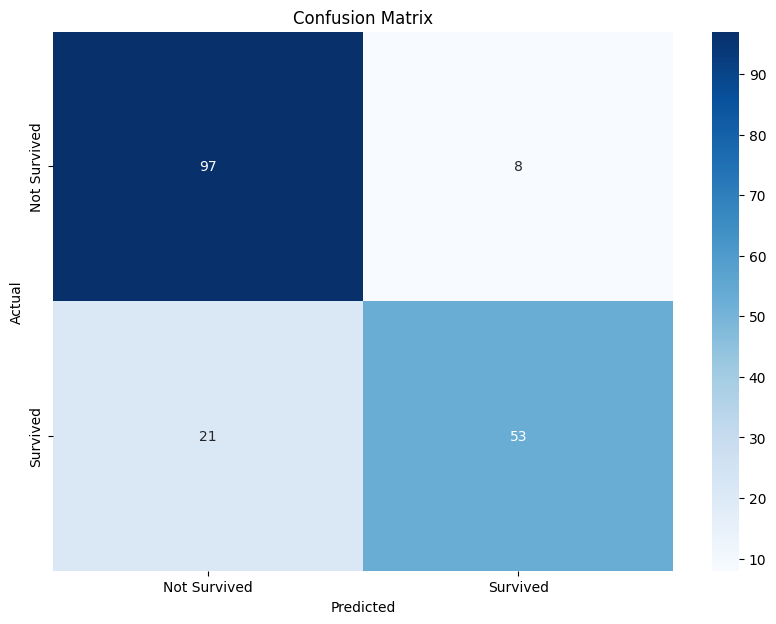

In [28]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()